In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Example data for the first choropleth map
# data1 = dict(
#     # type = 'choropleth_mapbox',
#     locations = ['USA', 'CAN', 'MEX'],
#     z = [1, 2, 3],
#     locationmode = 'country names',
#     colorscale = 'Blues',
#     colorbar_title = 'Data 1'
# )

import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
import pyproj
pyproj.datadir.set_data_dir('/Users/jm/Code/mapgpt-mvp/.conda/share/proj')
import matplotlib.pyplot as plt
import os
import sys
from dotenv import load_dotenv
import pandas as pd
import pydeck as pdk
from IPython.display import display
sys.path.append('../src')

from infrastructure.gpt4 import GPT4
from infrastructure.postgres_db import PostgresDB
from application.maps.choropleth_map import ChoroplethMap
import plotly.graph_objects as go

load_dotenv()

db_name = os.environ.get("DB_NAME")
db_user = os.environ.get("DB_USER")
db_password = os.environ.get("DB_PASSWORD")


db = PostgresDB(db_name=db_name, db_user=db_user, db_password=db_password)
comunas = db.run_gpd_query("SELECT * FROM comuna")

# Function to extract coordinates
def get_polygon_coordinates(geom):
    if geom.type == 'Polygon':
        return [(x, y) for x, y in geom.exterior.coords]
    elif geom.type == 'MultiPolygon':
        return [[(x, y) for x, y in polygon.exterior.coords] for polygon in geom.geoms][0]
    else:
        return None

comunas = comunas.to_crs(epsg=4326)
np.random.seed(9)
comunas = comunas.assign(
    lat = comunas.geom.centroid.y,
    lon = comunas.geom.centroid.x,
    coordinates = comunas.geom.apply(lambda geom: [list(coord) for coord in geom.geoms[0].exterior.coords]),
    coordinates2 = comunas.geom.apply(get_polygon_coordinates),
    score=lambda _df: np.random.randint(0, 101, size=len(_df)),
    score1=lambda _df: np.random.randint(0, 101, size=len(_df)),
    score2=lambda _df: np.random.randint(0, 101, size=len(_df)),
    score3=lambda _df: np.random.randint(0, 101, size=len(_df)),
    # geom = comunas.geom.simplify(10, preserve_topology=True)


    
)
# comunas.geom = comunas.geom.simplify(10, preserve_topology=True)
comunas = comunas.to_crs(epsg=3857)
c = comunas.set_index("codigo").head(10)
c.geom = c.geom.simplify(10, preserve_topology=True)
d = comunas.set_index("codigo").tail(10)
d.geom = d.geom.simplify(10, preserve_topology=True)


/Users/jm/Code/mapgpt-mvp/.conda/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/Users/jm/Code/mapgpt-mvp/.conda/lib/python3.11/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/Users/jm/Code/mapgpt-mvp/.conda/lib/python3.11/site-packages/geopandas/io/sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)
/var/folders/8j/bf4mjlj94czf88p79v8gb24w0000gp/T/ipykernel_32355/1578587683.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSe

In [32]:
from application.maps.bar_chart_map import BarChartMap

cols = ["score1", "score2", "score3"]
m = BarChartMap(c, cols)

display(m.fig)

In [60]:
from shapely import MultiPolygon
from shapely.affinity import translate


def nudge_polygons(multipolygons, distance=100):
    """Separate overlapping polygons by a small distance."""
    def displacement_vector():
        angle = np.random.uniform(0, 2 * np.pi)
        return distance * np.cos(angle), distance * np.sin(angle)
    
    nudged_multipolygons = []
    for multipolygon in multipolygons:
        # for polygon in multipolygon.geoms:
        new_multipolygon = multipolygon
        while any(new_multipolygon.distance(other_polygon) < 100 for other_polygon in nudged_multipolygons):
            dx, dy = displacement_vector()
            new_multipolygon = translate(new_multipolygon, xoff=dx, yoff=dy)
        nudged_multipolygons.append(new_multipolygon)
    
    return gpd.GeoSeries(nudged_multipolygons, crs=multipolygons.crs)


In [55]:
def displacement_vector():
        angle = np.random.uniform(0, 2 * np.pi)
        return 100 * np.cos(angle), 100 * np.sin(angle)

In [59]:
dx, dy = displacement_vector()
translate(m.raw_bars.iloc[0], xoff=dx, yoff=dy)

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

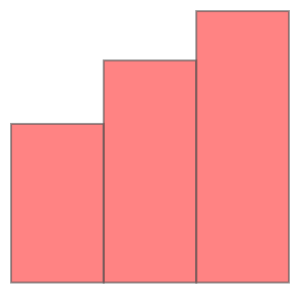

In [61]:
nudge_polygons(m.raw_bars).explore()

In [34]:
m.raw_bars.explore()

In [28]:
import folium

from application.maps.bar_chart_map import bar_chart_gdf

# fig = folium.Map(location=[-33.45, -70.6667], zoom_start=10)
fig = folium.Map(location=[float(c.to_crs(epsg=4326).centroid.y.mean()), float(c.to_crs(epsg=4326).centroid.x.mean())], zoom_start=8, width=500, height=500)
bars = bar_chart_gdf(c, cols)
colors = None
def style(feature):
    return {
        'fillColor': colors.get(feature['properties']['category']) if colors else 'blue',
        'fillOpacity': 0.8
    }

folium.GeoJson(c, tooltip=folium.GeoJsonTooltip(fields=["nombre"], aliases=["Nombre"], localize=True)).add_to(fig)
folium.GeoJson(bars, style_function=style, tooltip=folium.GeoJsonTooltip(
    fields=["category", "value"],
    aliases=["Candidato", "Valor"],
    localize=True)
).add_to(fig)

fig.fit_bounds(fig.get_bounds())

fig

/var/folders/8j/bf4mjlj94czf88p79v8gb24w0000gp/T/ipykernel_32355/287095728.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fig = folium.Map(location=[float(c.to_crs(epsg=4326).centroid.y.mean()), float(c.to_crs(epsg=4326).centroid.x.mean())], zoom_start=8, width=500, height=500)


In [27]:
import plotly.express as px
px.colors.qualitative.Plotly

['#636EFA',
 '#EF553B',
 '#00CC96',
 '#AB63FA',
 '#FFA15A',
 '#19D3F3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52']

In [19]:
fig.get_bounds()

[[-39.185807240891236, -73.062353166023],
 [-33.91882179886274, -70.32111478696243]]

In [16]:
c.centroid.y.mean(), c.centroid.x.mean()

(np.float64(-4311529.316941067), np.float64(-7972277.414814244))

In [14]:
c.centroid

codigo
12202    POINT (-7978461.141 -4078951.618)
6102      POINT (-7853283.57 -4036470.073)
6103     POINT (-7900472.252 -4066771.325)
6104     POINT (-7912315.998 -4063727.393)
9121     POINT (-8115440.796 -4662156.789)
9103     POINT (-8014123.185 -4718435.119)
9105     POINT (-8080502.115 -4715240.097)
9106     POINT (-8103127.715 -4642950.305)
6106     POINT (-7875523.678 -4037620.657)
6109     POINT (-7889523.698 -4092969.792)
dtype: geometry

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
m.bars.explore()

In [ ]:
%load_ext autoreload
%autoreload 2